In [ ]:
!pip install -r /content/drive/MyDrive/Colab_Notebooks/DWDM_Project/requirements.txt

In [ ]:
!pip install tabula-py

In [ ]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Scripts/Data_loading')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Scripts/Data_processing')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/cpbp.csv')
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/modis.csv')



In [ ]:
# Add your scripts directory
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Scripts')

from Data_loading import (
    load_cpcb_data,
    prepare_cpcb_dataframe,
    calculate_missing_aqi,
    load_modis_data,
    load_health_data
)
from Data_processing import process_comprehensive_analysis

# File paths
cpcb_file   = '/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/cpcb_final.csv'
modis_file  = '/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/modis.csv'
health_pdfs = [
    '/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/Health/SRS_STAT_2020.pdf',
    '/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/Health/SRS_STAT_2021.pdf'
]

# Results directory
results_dir = '/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Results'
os.makedirs(results_dir, exist_ok=True)

print("🚀 Starting Enhanced India AQI Analysis Pipeline (2015–2020)")

# Phase 1: Load & Prepare CPCB Data
print("📊 PHASE 1: DATA PREPARATION")
raw_df   = load_cpcb_data(cpcb_file)
clean_df = prepare_cpcb_dataframe(raw_df)
clean_df = calculate_missing_aqi(clean_df)
clean_df.to_csv(f"{results_dir}/cleaned_cpcb_data.csv", index=False)

# Phase 2: Comprehensive Analysis
print("🧮 PHASE 2: COMPREHENSIVE ANALYSIS")
analysis = process_comprehensive_analysis(clean_df)

# Save analysis outputs
analysis['daily'].to_csv(f"{results_dir}/daily_summary.csv", index=False)
analysis['city'].to_csv(f"{results_dir}/city_summary.csv", index=False)
analysis['yearly'].to_csv(f"{results_dir}/yearly_summary.csv", index=False)
analysis['seasonal'].to_csv(f"{results_dir}/seasonal_summary.csv", index=False)

# Phase 3: Load MODIS Satellite Data
print("🛰️ PHASE 3: MODIS DATA")
modis_df = load_modis_data(modis_file)
modis_df.to_csv(f"{results_dir}/modis_data.csv", index=False)

print("✅ Pipeline completed. Results saved to:", results_dir)


🚀 Starting Enhanced India AQI Analysis Pipeline (2015–2020)
📊 PHASE 1: DATA PREPARATION


/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Scripts/Data_loading.py:34: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date_parsed'] = pd.to_datetime(df['date'], infer_datetime_format=True, errors='coerce')


🧮 PHASE 2: COMPREHENSIVE ANALYSIS
🛰️ PHASE 3: MODIS DATA


🏥 PHASE 4: HEALTH STATISTICS


Sep 19, 2025 1:35:48 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Sep 19, 2025 1:35:48 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Sep 19, 2025 1:35:49 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Sep 19, 2025 1:35:49 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Sep 19, 2025 1:35:49 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Sep 19, 2025 1:35:49 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Sep 19, 2025 1:35:49 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Sep 19, 2025 1:35:49 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Sep 19, 2025 1:35:49 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Sep 19, 2025 1:35:50 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Sep 19, 2025 1:35:50 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Sep 19, 2025 1:35:50 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Sep 19, 2025 1:35:50 PM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

   Loaded and saved health statistics
✅ Pipeline completed. Results saved to: /content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Results


In [6]:
import pandas as pd

# Load dataset
file_path = "/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/Health/HMIS report of all States and Districts Across the Months for 2019-20.csv"
df = pd.read_csv(file_path, encoding="ISO-8859-1")

# Map HMIS parameter names → your required columns
parameter_map = {
    "Inpatient - Asthma, Chronic Obstructive Pulmonary Disease (COPD), Respiratory infections": "Asthma/COPD Cases",
    "Childhood Diseases - Asthma": "Asthma Cases",
    "Inpatient – COPD": "COPD Cases",
    "Children admitted with upper respiratory infections": "Respiratory Hospitalizations",
    "Number of Child Deaths (1 -5 years) due to Pneumonia": "Respiratory Mortality",
    "Number of Adolscent / Adult deaths due to Respiratory diseases including infections (other than TB)": "Respiratory Mortality",
    "Childhood Diseases - Pneumonia": "Other Respiratory Illness Cases"
}

# Keep only matching rows
respiratory_df = df[df["Parameters"].isin(parameter_map.keys())].copy()

# Replace names with your clean column categories
respiratory_df["Parameters"] = respiratory_df["Parameters"].map(parameter_map)

# Reshape into long format
month_cols = [c for c in df.columns if "-" in c]
id_cols = ["State", "Parameters"]
if "District" in df.columns:
    id_cols.insert(1, "District")

resp_long = respiratory_df.melt(
    id_vars=id_cols,
    value_vars=month_cols,
    var_name="Month",
    value_name="count"
)

# Clean month names
resp_long["Month"] = resp_long["Month"].str.split("-").str[0].str.strip()

# Add Year (2019 Apr–Dec, 2020 Jan–Mar)
month_to_year = {m:2019 for m in ["April","May","June","July","August","September","October","November","December"]}
month_to_year.update({m:2020 for m in ["January","February","March"]})
resp_long["Year"] = resp_long["Month"].map(month_to_year)

# Drop NaNs
resp_long = resp_long.dropna(subset=["count"])

# Save updated filtered file
output_path = "/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/Health/updated_Respiratory_HMIS_2019_20.csv"
resp_long.to_csv(output_path, index=False)

print("✅ Clean respiratory dataset saved at:", output_path)
print(resp_long.head(20))


✅ Clean respiratory dataset saved at: /content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/Health/updated_Respiratory_HMIS_2019_20.csv
                State                       Parameters  Month    count    Year
0       A & N Islands  Other Respiratory Illness Cases  April      0.0  2019.0
1       A & N Islands                     Asthma Cases  April      0.0  2019.0
2       A & N Islands     Respiratory Hospitalizations  April     34.0  2019.0
3       A & N Islands                Asthma/COPD Cases  April    116.0  2019.0
4       A & N Islands            Respiratory Mortality  April      0.0  2019.0
5       A & N Islands            Respiratory Mortality  April      0.0  2019.0
6      Andhra Pradesh  Other Respiratory Illness Cases  April   1030.0  2019.0
7      Andhra Pradesh                     Asthma Cases  April    723.0  2019.0
8      Andhra Pradesh     Respiratory Hospitalizations  April   1112.0  2019.0
9      Andhra Pradesh                Asthma/COPD Cases  April  10915.0 

/tmp/ipython-input-353984913.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding="ISO-8859-1")


In [157]:

#load all clean datasets for aggregation and merging
cpcb_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Results/cleaned_cpcb_data.csv')
health_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Data/Health/updated_Respiratory_HMIS_2019_20.csv')
modis_df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/DWDM_Project/Results/modis_data.csv')


In [158]:
# --- Clean health dataset ---
#all months lowercase and strip spaces
health_df['Month'] = health_df['Month'].astype(str).str.strip().str.lower()

#mapping dictionary with lowercase keys
month_map = {
    'january': 1, 'february': 2, 'march': 3, 'april': 4,
    'may': 5, 'june': 6, 'july': 7, 'august': 8,
    'september': 9, 'october': 10, 'november': 11, 'december': 12
}

# Step 3: Remove 'total' rows and map to integers
health_df = health_df[health_df['Month'] != 'total']
health_df['Month'] = health_df['Month'].map(month_map)
# Drop rows with null months after mapping
health_df = health_df[health_df['Month'].notnull()]

# Normalize state names to lowercase and strip spaces
health_df['State'] = health_df['State'].str.strip().str.lower()

# --- Clean CPCB dataset ---
# Map CPCB cities to states
city_to_state = {
    'Ahmedabad': 'gujarat',
    'Aizawl': 'mizoram',
    'Amaravati': 'andhra pradesh',
    'Amritsar': 'punjab',
    'Bengaluru': 'karnataka',
    'Bhopal': 'madhya pradesh',
    'Brajrajnagar': 'odisha',
    'Chandigarh': 'chandigarh',
    'Chennai': 'tamil nadu',
    'Coimbatore': 'tamil nadu',
    'Delhi': 'delhi',
    'Ernakulam': 'kerala',
    'Gurugram': 'haryana',
    'Guwahati': 'assam',
    'Hyderabad': 'telangana',
    'Jaipur': 'rajasthan',
    'Jorapokhar': 'jharkhand',
    'Kochi': 'kerala',
    'Kolkata': 'west bengal',
    'Lucknow': 'uttar pradesh',
    'Mumbai': 'maharashtra',
    'Patna': 'bihar',
    'Shillong': 'meghalaya',
    'Talcher': 'odisha',
    'Thiruvananthapuram': 'kerala',
    'Visakhapatnam': 'andhra pradesh'
}

cpcb_df['state'] = cpcb_df['city'].map(city_to_state)

# Keep only relevant columns and lowercase state names
cpcb_df['state'] = cpcb_df['state'].str.strip().str.lower()

# Extract year and month from date if not already done
cpcb_df['date'] = pd.to_datetime(cpcb_df['date'])
cpcb_df['year'] = cpcb_df['date'].dt.year.astype(str)
cpcb_df['month'] = cpcb_df['date'].dt.month.astype(str)

# Aggregate CPCB pollution data monthly at state level
state_cpcb = cpcb_df.groupby(['state', 'year', 'month']).agg({
    'pm25': 'mean',
    'pm10': 'mean',
    'aqi': 'mean'
}).reset_index()

# Aggregate health data monthly by state and parameter
health_monthly = health_df.groupby(['State', 'Year', 'Month', 'Parameters']).agg({
    'count': 'sum'
}).reset_index()

# Pivot health data to get each respiratory parameter as a column
health_pivot = health_monthly.pivot_table(index=['State', 'Year', 'Month'],
                                         columns='Parameters',
                                         values='count').reset_index()
health_pivot['Year'] = health_pivot['Year'].astype(float).astype(int)
state_cpcb['year'] = state_cpcb['year'].astype(int)
state_cpcb['month'] = state_cpcb['month'].astype(int)

# Lowercase state, year, month columns for consistency in health data
health_pivot.rename(columns=lambda x: x.lower(), inplace=True)

merged_df = pd.merge(state_cpcb, health_pivot,
                     on=['state', 'year', 'month'],
                     how='inner')

# Check merged data
print("Merged DataFrame shape:", merged_df.shape)
print(merged_df.head())

Merged DataFrame shape: (227, 11)
            state  year  month       pm25        pm10         aqi  \
0  andhra pradesh  2019     10  24.610179   57.906786   75.888946   
1  andhra pradesh  2019     11  65.352000  114.287500  135.841333   
2  andhra pradesh  2019     12  57.888548   96.840000  123.387097   
3  andhra pradesh  2019      4  23.761695   75.591695   85.544553   
4  andhra pradesh  2019      5  40.100000  121.848226  114.719797   

   asthma cases  asthma/copd cases  other respiratory illness cases  \
0        3666.0            33942.0                           5055.0   
1        3198.0            35358.0                           3771.0   
2        4269.0            33585.0                           3657.0   
3        2169.0            32745.0                           3090.0   
4        2211.0            31515.0                           2031.0   

   respiratory hospitalizations  respiratory mortality  
0                        5604.0                 1128.0  
1         

EDA

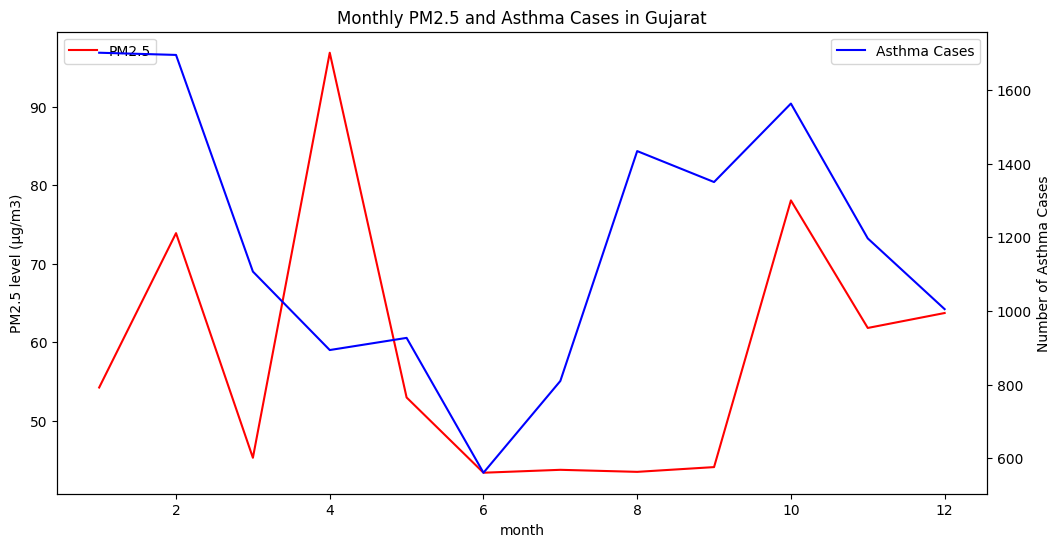

PM2.5 and Asthma Cases correlation in Gujarat: 0.18


In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Plot monthly average PM2.5 and asthma cases for a state

state_data = merged_df[merged_df['state'] == 'gujarat']

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

sns.lineplot(data=state_data, x='month', y='pm25', ax=ax1, color='red', label='PM2.5')
sns.lineplot(data=state_data, x='month', y='asthma cases', ax=ax2, color='blue', label='Asthma Cases')

ax1.set_ylabel('PM2.5 level (µg/m3)')
ax2.set_ylabel('Number of Asthma Cases')
ax1.set_title('Monthly PM2.5 and Asthma Cases in Gujarat')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# Calculate Pearson correlation
corr = state_data[['pm25', 'asthma cases']].corr().iloc[0,1]
print(f"PM2.5 and Asthma Cases correlation in Gujarat: {corr:.2f}")


In [169]:
state_data

,state,year,month,pm25,pm10,aqi,asthma cases,asthma/copd cases,other respiratory illness cases,respiratory hospitalizations,respiratory mortality
55,gujarat,2019,10,78.065161,146.732258,608.679032,1563.0,22356.0,2124.0,10932.0,1875.0
56,gujarat,2019,11,61.803667,111.900333,451.000000,1197.0,15222.0,2022.0,8535.0,1461.0
57,gujarat,2019,12,63.708065,109.828065,293.548387,1005.0,16356.0,2112.0,10644.0,1602.0
58,gujarat,2019,4,96.889643,NaN,628.750000,894.0,14676.0,1836.0,6762.0,1794.0
59,gujarat,2019,5,52.941071,136.410000,405.729157,927.0,14004.0,1860.0,6255.0,1824.0
60,gujarat,2019,6,43.349667,117.498667,395.133333,561.0,11163.0,1596.0,6837.0,1716.0
61,gujarat,2019,7,43.720323,117.014138,481.161290,810.0,15723.0,2151.0,7467.0,1590.0
62,gujarat,2019,8,43.460645,137.300968,516.870968,1434.0,20835.0,2208.0,9672.0,1782.0
63,gujarat,2019,9,44.066897,86.397778,456.914655,1350.0,20205.0,2085.0,11739.0,1842.0
64,gujarat,2020,1,54.211613,113.567419,271.176194,1701.0,19146.0,2418.0,9192.0,1758.0


In [170]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Use pollution variables to predict asthma cases

X = merged_df[['pm25', 'pm10', 'aqi']]
y = merged_df['asthma cases']

# Remove rows with missing values
X = X.fillna(0)
y = y.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Regression MSE:", mean_squared_error(y_test, y_pred))
print("Regression coefficients:", model.coef_)


Regression MSE: 8022318.252755295
Regression coefficients: [ 48.1565849  -23.27729519  -4.45175384]
